In [1]:
# ! python -m site
### installing package in jupyter notebook
# import sys # replace the path below with the location of your .whl file :
#!{sys.executable} -m pip install C:\Users\BuruzsA\PycharmProjects\flows1d\dist\flows1d-1.0.0b4-py3-none-any.whl
## if you want to uninstall for test/updates 

In [2]:
import logging
import sys
logging.basicConfig(stream = sys.stdout, level = logging.INFO)

In [3]:
#sys.path.append("C:/Users/BuruzsA/PycharmProjects/")
sys.path.append("C:/Users/BuruzsA/PycharmProjects/flows1d") ## this is not needed, if the package is installed in jupyter
from flows1d.core import nozzleFactory, NozzleParams, nozzleSolver, EjectorGeom, refProp, EjectorMixer

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
import importlib
import math

%matplotlib notebook

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
from time import time
t0 = time()
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 140)
np.core.arrayprint._line_width = 180
np.set_printoptions(linewidth= 180)

In [5]:
nozzle = nozzleFactory.ConicConic(Rin = 1.0, Lcon=2.905, Rt = 0.2215, Ldiv = 1.4116, Rout = 0.345 )
nozzle.setFriction( 1.0e-2 )
ejector = EjectorGeom(nozzle, Dm = 1.4 )
ejector.setMixer(mixerstart=5.514, mixerLen=11.2, diffuserLen=25.2, diffuserHeight=1.80)
ejectorPlot = ejector.draw()
## Butane ejector for heat pump see Schlemminger article
pin = 2140.0  # kPa  2000
Tin = 273.15 + 114.0  # Kelvin  380
Tsuc =  52.7 + 273.15 #  suction temperature
Psuc =  430 # suction pressure kPa
fluid = "BUTANE"
RP = refProp.setup(fluid)
[Din, hin] = refProp.getDh_from_TP(RP, Tin, pin)
[DinSuc, hinSuc] = refProp.getDh_from_TP(RP, Tsuc, Psuc)
hin, hinSuc

<IPython.core.display.Javascript object>

(506.91123909841775, 664.5143552744445)

## Calculating primary nozzle mass flow rate, and critical flow speed

In [6]:
nsolver = nozzleSolver.NozzleSolver(nozzle, fluid, 1, solver="AdamAdaptive", mode="basic")
nsolver.setFriction(1e-2)
vin_crit = nsolver.calcCriticalSpeed(pin, hin, 0.1, maxdev= 1e-3, chokePos="divergent_part" )
vin_crit

friction of the flow calc set to 0.01
{'massflow': 0.04155902122068258}
INFO:root: x interval end reached xlast 4.300000000000001 +  dX 0.1 vs xend 4.316599999999999
INFO:root:solver finished in 45 iterations. final point xlast =4.316599999999999
{'massflow': 0.08311804244136516}
INFO:root: x interval end reached xlast 4.300648980804252 +  dX 0.03751622452010628 vs xend 4.316599999999999
INFO:root:solver finished in 70 iterations. final point xlast =4.316599999999999
{'massflow': 0.1662360848827303}
INFO:root: x interval end reached xlast 4.316275383491287 +  dX 0.009084710155748603 vs xend 4.316599999999999
INFO:root:solver finished in 200 iterations. final point xlast =4.316599999999999
1.2
{'massflow': 0.3324721697654606}
3 dimensional Newton Raphson has not converged in 100 iterations
error = 2.6967061365964065
INFO:root:Newton root finding failed at 2.624718426718262 + 0.00014812436054771158
3 dimensional Newton Raphson has not converged in 100 iterations
error = 0.006007196797042

1.3353515625

In [7]:
dv_kick = 1.5
dp_kick = nsolver.pFromV_MassConst(v = vph_throat["v"], dv = dv_kick, p = vph_throat["p"], h = vph_throat["h"])
print(f"mass conserving artificial kick: dv = {dv_kick} m/s, dp = {dp_kick} kPa")
res_crit = nsolver.solveKickedNozzle(vin_crit, pin , hin, kicks = {'v': 1 , 'p': 0})
nsolver.plotsol(res_crit, title = "choked nozzle with friction = {} ".format(nsolver.frictionCoef))

NameError: name 'vph_throat' is not defined

In [ ]:
nozzleExit =  res_crit.iloc[-1]
plt.figure()
plt.plot(res_crit['x'], res_crit['v'])
plt.plot(res_crit['x'], res_crit['c'])
plt.legend(["velocity", "speed of sound"])

In [ ]:
massFlowPrim = nozzleExit['v']* nozzleExit['d']* nozzle.Aprofile(nozzle.L) * 1e-4
print(f"calculated primary mass flow rate  {round(massFlowPrim, 5)} kg/sec") # in kg/sec

# Mixing calculations

In [ ]:
mixingParams = { 'massExchangeFactor' : 1.e-4, 'dragFactor': 0.003, 'frictionInterface': 0.001, 'frictionWall': 0.015}
mixer = EjectorMixer.EjectorMixer(fluid, ejector, mixingParams)

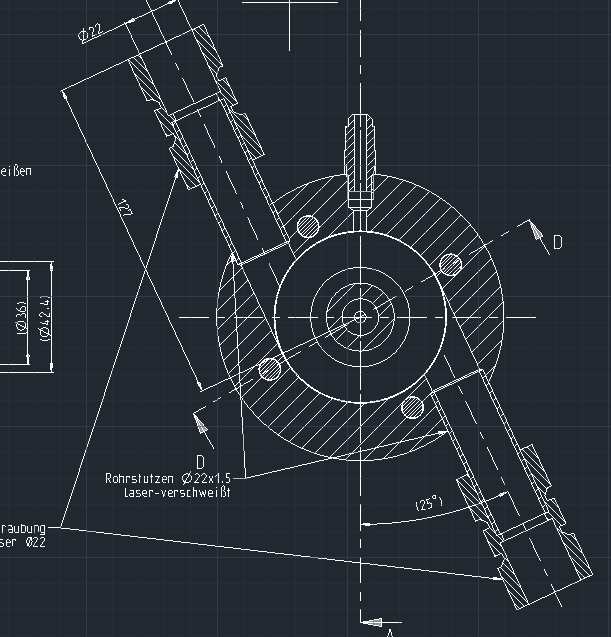

Approximated Suction Area = 2 * (2.2cm/2)^2 * \Pi

In [ ]:
calcSucMassFlow = True
if calcSucMassFlow == False:
    # Single Choking calculation. With externally set suction mass flow rate:
    MFlowSuc = 58.0
    mixer.setSuctionMassFlow(MFlowSuc) # set the suction mass flow rate in [g/s]b

    entrainment = mixer.massFlowSecond / 1000.0 / massFlowPrim
    entrainment

    preMix = mixer.premixWrapSolve(res_crit, Psuc ,Tsuc)
    preMix
    mixerinput = [ preMix[key] for key in [  'py', 'vpy', 'vsy', 'hpy', 'hsy', 'Apy', 'Asy']]

    solMix = mixer.solveMix(mixerinput)
else:
    mixer.setSuctionMassFlow(None)
    mixer.setSingleChoke(True)
    mixer.ejector.Asi = 2* 1.1**2 * math.pi  # cm2 of the suction nozzle inlet.
    #mixer.ejector.Asi = 2*3.14*3.25*2.2
    preMix = mixer.premixWrapSolve(res_crit, Psuc ,Tsuc)
    preMix
    print(f"calculated secondary mass flow rate {preMix['massFlowSecond']} g/s")
    mixerinput = [ preMix[key] for key in [  'py', 'vpy', 'vsy', 'hpy', 'hsy', 'Apy', 'Asy']]
    solMix = mixer.solveMix(mixerinput)

In [ ]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 18px;
}
.dataframe td {
    font-size: 20px;
}
</style>

In [ ]:
MFR_data = [ [0.127,massFlowPrim  ] , [0.058, preMix['massFlowSecond'] *1e-3 ] ]
mass_flows = pd.DataFrame(MFR_data, index = ["Primary Nozzle", "Suction Nozzle"] , columns= ["Experiment", "This Simulation"])
mass_flows.index.name = "MassFlowRate kg/s"
mass_flows

Experiment from Christian Schlemminger1*, Christian Kopp1, Krzysztof Banasiak1, Gerwin Drexler-Schmid2, Michael Lauermann2, Bernd Windholz2, Christoph Zauner2, Alexander Baumhakel3: Hochtemperatur Wärmepumpe mit Ejektor 2019 DKV Tagung

In [1]:
print(solMix)

NameError: name 'solMix' is not defined

In [ ]:
mixer.plotSolution(res_crit, solMix, "single choking mode",  ejectorPlot)

In [ ]:
Pdiffout = solMix.iloc[-1]['p']
diffusorLast =  solMix.iloc[-1]
primState =  refProp.getTD(RP, diffusorLast['hp'] , diffusorLast['p'])
secState = refProp.getTD(RP, diffusorLast['hs'] , diffusorLast['p'])
primState, secState
massFPrim = primState['D'] * diffusorLast['vp']* diffusorLast['Ap']* 1e-4
massFSec = primState['D'] * diffusorLast['vs']* diffusorLast['As']* 1e-4
massFPrim , massFSec
efficiency = mixer.calcEfficiency(pin, Tin, Psuc, Tsuc, Pdiffout, massFPrim , massFSec )
print(f"Ejector efficiency {round(efficiency,4)}")

In [ ]:
def specPlotSolution(ejector, RP, solNozzle, solMix, title="", ejectorPlot=True,
                     pressureExp = None):
    """ Plot the results of solveMix function
    :param solNozzle: solution of the nozzle
    :param solMix: the solution dataframe with data that we get from the solveMix function
    :return:
    """
    fig = plt.figure(figsize=[11, 8])
    fig.suptitle("results of the 1D flow ejector simulation \n " + title)
    if (ejectorPlot):
        plt.subplot(311)
        # plt.plot(ejectorPlot)
        nozzleWall = [ejector.nozzle.Rprofile(xi) for xi in solNozzle['x']]
        mixerWall = [ejector.mixerR(xi) for xi in solMix['x']]
        plt.plot(solNozzle['x'], nozzleWall)
        plt.plot(solMix['x'], np.sqrt(solMix['Ap'] / math.pi))
        plt.plot(solMix['x'], mixerWall)
        plt.legend(['wall of Nozzle', 'primary motive stream', 'wall of Mixing region'])
        plt.ylabel("R [cm]")

    if ejectorPlot:
        plt.subplot(312)
    else:
        plt.subplot(211)
    if pressureExp is None:
        plt.plot(solNozzle['x'], solNozzle['p'], color = 'C0')
        plt.plot(solMix['x'], solMix['p'], color='C0')
        # speeds
        plt.plot(solNozzle['x'], solNozzle['v'], color="#aa1111")
        plt.plot(solMix['x'], solMix['vp'], color="#aa1111")
        plt.plot(solMix['x'], solMix['vs'], color="#aa9911")
        ## enthalpy
        plt.plot(solMix['x'], solMix['hp'])
        plt.legend(['pressure [kPa]', 'p [kPa]',
                    'prim flow speed', 'prim flow speed', 'suction flow speed',
                    'hp'])
        plt.yscale("log")
        plt.xlabel("x [cm]")
    else:
        plt.plot(solNozzle['x'], solNozzle['p'], color='C0')
        plt.plot(solMix['x'], solMix['p'], color='C0')
        plt.plot(pressureExp['x'], pressureExp['p'], color = 'red', marker = 'x', linestyle = '')
        plt.legend(['pressure simulation [kPa]', '',
                    'pressure Experiments [kPa]' ] )
        plt.xlabel("x [cm]")
        plt.ylabel("kPa")
        plt.yscale("log")
        plt.grid(True, axis = 'y')
    ## Mach numbers :
    if ejectorPlot:
        plt.subplot(313)
    else:
        plt.subplot(212)
    plt.plot(solNozzle['x'], solNozzle['mach'], color = 'C0')
    cPrim = [refProp.getSpeedSound(RP, solMix.iloc[i]['hp'], solMix.iloc[i]['p']) for i in range(solMix.__len__())]
    cSec = [refProp.getSpeedSound(RP, solMix.iloc[i]['hs'], solMix.iloc[i]['p']) for i in
            range(solMix.__len__())]
    plt.plot(solMix['x'], solMix['vp'] / cPrim, color = 'C0')
    plt.plot(solMix['x'], solMix['vs'] / cSec, color = 'C1' )
    plt.legend(['primary Mach', 'primary Mach', 'secondary Mach'])
    plt.tight_layout()
    plt.axvline( x = ejector.nozzle.xt, linestyle = '--', color = '#444444' )
    plt.text(ejector.nozzle.xt, 0.0, 'motive nozzle throat', va = 'bottom', rotation = 90, alpha = 0.6)
    # text1 = plt.annotate('motive nozzle throat', xy=(ejector.nozzle.xt, 0.3), va='top', rotation = 90)
    # text1.set_alpha(.7)
    mixend = ejector.ejectorlength - ejector.diffuserLen
    plt.axvline( x = mixend, linestyle = '--', color = '#444444' )
    text2 = plt.annotate('diffuser', xy=(mixend, 0), va='bottom',alpha = 0.6)
    # text2.set_alpha(.7)


In [ ]:
pressureExp = pd.DataFrame( {'x': [ 5.5, 11.1, 16.7, 29.3, 41.9],
                              'p' : [ 404.4, 461.7, 520.2, 579.2, 584.5]})
specPlotSolution(ejector, RP, res_crit, solMix, "single choking mode",  False, pressureExp)